# Machine Learning for Coders

This set of tutorials will serve as an introduction to machine learning for coders. There will not be much talk in terms of math, except for when necessary. Machine learning has gotten extremely popular over the past decade. Most large scale companies have machine learning engineers or data scientists to help make business decisions. These tutorials are not meant to get you to the level of them, but rather introduce you to the field. By following these tutorials you will gain hands-on experience with building, developing, training, and testing models. You will gain an understanding for data cleaning, when to apply it, and how. You will learn about the three areas that most machine learning can be categorized to: supervised, unsupervised, and reinforcement learning. I will introduce them in that order and may circle back when necessary. Since I won't be discussing mathematical reasoning, I will link to tutorials or other online material in case you'd like to further your understanding.

These tutorials will build upon each other so you may want to go through them in order. I will place `# $MODIFY ` comments at areas where you can modify values. These values are meant to be modified once you've gone through the tutorial once. I'll list out a set of tasks at the end of each tutorial with instructions on what to try and what to look for. Then, circle back to see how changing values effects the code.

All code will be in Python 3.x. If you don't already have that, go ahead and install Python 3.7 or newer. There are three main frameworks we could use: PyTorch, TensorFlow, or JAX. TensorFlow was what everyone used for a long time. TensorFlow 1.x was hard to work with but well tuned. TensorFlow 2.x came about and was meant to be easier to work with. There were a number of bugs and upgrading code from the old to the new version was difficult. JAX came along because of this (released by Google) and addresses many of the issues with TensorFlow. PyTorch is generally thought of as a researcher tool, but it can also be used for production. I'll be using PyTorch in these tutorials. Most current state of the art (sota) models are developed using PyTorch. I find it easier to work with, easy to set up, and easy to debug. 

## Supervised Learning
Let's start by discussing supervised learning. This type of learning relies on labeled data. This label might be binary (0 or 1), categorical ("cat", "dog", "potato"), real (1.23, 3.1415926...), or really anything. The main point here is that you have something you use to label your data.

So what's your data? Well... technically numbers. Computers don't just know language or images. All of these get converted to numbers at some point. But the data is composed of features. These features might be known (number of bathrooms in a house, sq ft, number of bedrooms), or learned (computer vision and natural language processing both tend to learn features about their data).

### Half Moon
This tutorial will focus on a half-moon dataset. This type of dataset consists of two half-moon type structures which you will see shortly. There will be two features: x-position and y-position and a binary label representing which class it belongs to.


In [ ]:
# This cell is meant to install dependencies within google colab
def _install_deps():
    try:
        if 'google.colab' in str(get_ipython()):
            print('Installing dependencies within Google Colab...')
            !wget https://github.com/Chrispresso/ML-for-coders/blob/main/requirements.txt?raw=True -O requirements.txt
            !python -m pip install -r requirements.txt
    except:
        pass

try:
    if __cell_install_requirements:
        _install_deps()
    else:
        pass
except:
    _install_deps()

__cell_install_requirements = False

In [1]:

import torch
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
import imageio
from IPython import display
# "%" are "magic" operators in Jupyter Notebooks. I use load_ext to allow this to load into the notebook
%load_ext tensorboard

/bin/bash: /opt/anaconda/v3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done
/bin/bash: /opt/anaconda/v3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done
/bin/bash: /opt/anaconda/v3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda/v3/envs/py39

  added / updated specs:
    - pytorch-lightning==1.7.6


The following packages will be DOWNGRADED:

  pytorch-lightning                      1.7.7-pyhd8ed1ab_0 --> 1.7.6-pyhd8ed1ab_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Retrieving notices: ...working... done
/bin/bash: /opt/anaconda/v3/lib/libtinfo.so.6: no version

/opt/anaconda/v3/envs/py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /mnt/zpool/SATA3500GB_12RAIDZ3_Pool/INTEL/LABS/opt/anaconda/v3/envs/py39/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
print(torch.__version__)
print(pl.__version__)

1.12.1.post200
1.7.6


### Graphs
Since this tutorial is meant for coders, I assume you know about graph structures and won't discuss them much. I will however quickly mention that machine learning frameworks (TensorFlow included) rely on graphs to help know when operations are done so that the gradients can flow backwards (backpropagation) to help update the weights. The weights are key components to machine learning models and are what ultimately determines if something will be classified as one class or another. These weights are learned in model training but the discussion of backpropagation is beyond the scope of this tutorial. For a good intro you can watch [this](https://www.youtube.com/watch?v=Ilg3gGewQ5U)  video by 3B1B.

Let's start by seeing how you can use PyTorch to take a derivative of $$3x^{2} + 4x + 5$$ at `x=2`

In [3]:
x = torch.tensor(2.0, requires_grad=True)
x

tensor(2., requires_grad=True)

In [4]:
y = 3*x**2 + 4*x + 5
y

tensor(25., grad_fn=<AddBackward0>)

Manually compute the derivative and plug in at `x=2`. This is purely Python and not relying on PyTorch.

In [5]:
dy_dx = lambda x: 6*x + 4
dy_dx(2.0)

16.0

Now instead let's use PyTorch to take the derivative. We do this by calling `.backward()`. In this case we go backwards through the graph of `y` and then look at the gradient at `x`.

In [6]:
y.backward()
x.grad

tensor(16.)

It might seem silly to use PyTorch for that, but in order to train a neural network we'll need to minimize a loss function. A good way to minimize something is to take a derivative and set it equal to zero and solve. We're not going to be able to solve for an absolute minimum but by taking small steps in the direction of the largest gradient, we'll be able to slowly make our way to the minimum. This is the basis of gradient descent, which is one of the original ways to train a neural network.

Let's now get our dataset loaded.

In [7]:
import matplotlib.pyplot as plt
from sklearn import datasets
plt.ioff()
plt.style.use('seaborn')

In [8]:
sklearn_datasets = [datasets.make_circles, datasets.make_moons]
# $MODIFY 1
idx = 1
assert idx < 2, "idx must be 0 or 1"
sklearn_dataset = sklearn_datasets[idx]

X, y = sklearn_dataset(n_samples=1000, shuffle=True, noise=0.1, random_state=0xC0FFEE)
print(X.shape)
print(y.shape)


(1000, 2)
(1000,)


Look at the shape of `X`. Each row is an entry consisting of 2 features. Those features are what the model will be trained on. In this case those features are the (x,y) coordinate. Let's see what the classes are of a few of them. These will be stored in `y`.

In [9]:
print(y[:5])

[0 1 0 0 1]


Now let's separate the data into their individual classes. This is only for viewing purposes.

In [10]:
x0 = X[y==0]
x1 = X[y==1]
print(x0.shape)
print(x1.shape)

(500, 2)
(500, 2)


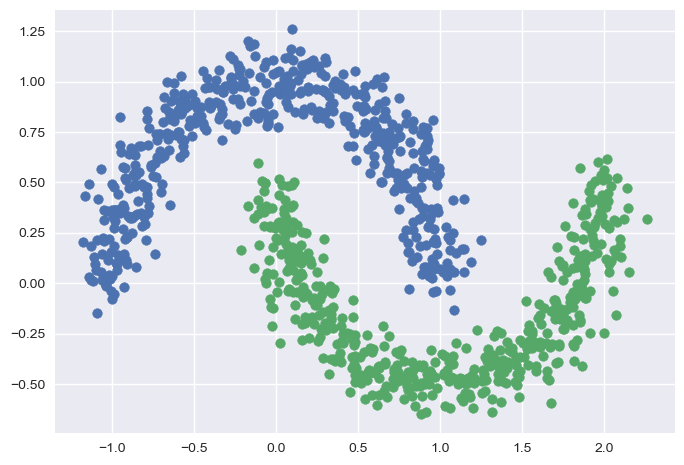

In [11]:
plt.scatter(x0[:,0], x0[:,1])
plt.scatter(x1[:,0], x1[:,1])
plt.show()
plt.close()

Neural networks are also refered to as "non-linear function approximators". Look at the data above and try to find a a straight line that would be able to separate the data. You might be able to get decent accuracy, but it's never going to be that good. Now, if I said you can place a polynomial down of degree=2, then maybe it gets better accuracy. The higher the degree the more you can precisely fit your data. There may exist some polynomial function that gets the highest accuracy for the above data. We don't know that function but we can try to approximate it. As the neural network trains, the weights are learned that cause it to take the shape of that function. Note that this doesn't have to be a polynomial.

Let's create a simple neural network and see.

In [12]:
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

Let's make a neural network with one hidden layer of 4 units.

In [13]:
torch.manual_seed(0xC0FFEE)  # For initial reproducibility
net = Network(4)
sample = torch.tensor([[1,1]]).float()
sample.shape
net(sample)

tensor([[0.4865]], grad_fn=<SigmoidBackward0>)

Let's see what the accuracy is of a randomly initialized network. 

In [14]:
def accuracy(model, X, y_true):
    # model.train(False) does a couple additional things that aren't needed in this case, but will be used in future
    # tutorials, so I wanted to introduce it at least. The `with torch.no_grad()` is used to let PyTorch know it doesn't
    # need to accumulate gradients since we won't be updating the weights
    model.train(False)
    with torch.no_grad():
        X_tensor = torch.tensor(X).float()
        y_pred = model(X_tensor)
        y_pred = torch.round(y_pred).numpy()
    
    y_pred = y_pred.ravel()
    acc = (y_pred == y_true).sum() / float(len(y_pred))
    model.train(True)
    
    return acc

In [15]:
accuracy(net, X, y)

0.6

You can ignore the code below. It's used for showing decision bounadries.

In [16]:
from torch.autograd import Variable
import numpy as np

# Adapted from https://gist.github.com/erwan-simon/e3baef06a00bb9a39a6968acf78121ee
def plot_decision_boundary(dataset, labels, model, steps=1000, color_map='Paired'):
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    steps = steps
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    model.train(False)
    with torch.no_grad():
        labels_predicted = model(Variable(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()))
    model.train(True)

    # Plot decision boundary in region of interest
    labels_predicted = [0 if value < 0.5 else 1 for value in labels_predicted.detach().numpy()]
    z = np.array(labels_predicted).reshape(xx.shape)
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)

    # Get predicted labels on training data and plot
    model.train(False)
    with torch.no_grad():
        train_labels_predicted = model(dataset)
    model.train(True)
    
    ax.scatter(dataset[:, 0], dataset[:, 1], c=labels.reshape(labels.size()[0]), cmap=color_map, lw=0)
    return fig, ax



Let's take a look at the decision boundary of this network. You'll notice that it's pretty bad. That's because the weights have not been learned and the network is essentially placing a random function down to separate the data.

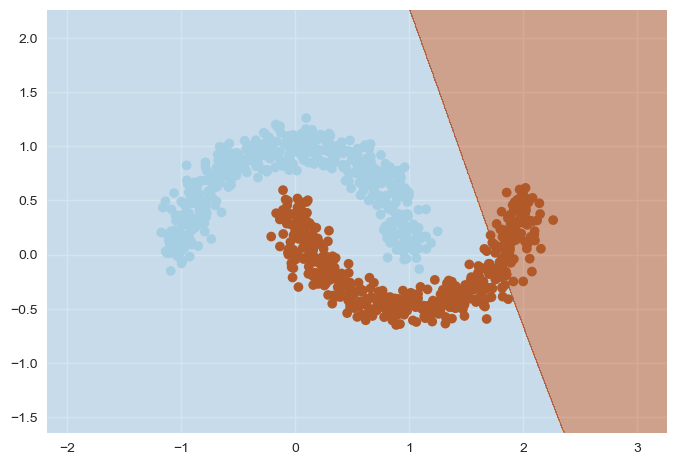

In [17]:
fig, _ = plot_decision_boundary(torch.tensor(X).float(), torch.tensor(y).float(), net, steps=1000)
plt.show()
plt.close(fig)


In order to train our model we need a way to access the data. PyTorch offers a number of ways to access data. The first is to create a `Dataset` which will hold the data. You'll need to provide `__len__` and `__getitem__` functions for it to return the length of the data and the data at a specific index, respectively.

In [18]:
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return self.X.size(0)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        
        return (X, y)

In [19]:
dataset = CustomDataset(X, y)

Below we can access a single data point. It's a tuple of tensors. The first item in the tuple is the (x, y) pair and the second item is the class the data point belongs to.

In [20]:
dataset[0]

(tensor([-0.1332,  1.1857]), tensor(0.))

Now we use a `DataLoader` to handle loading, batching and shuffling the data. Neural networks are really good at learning patterns. If you feed the data into the model the same way each time, the model might learn how it's getting fed in and not generalize well later on. In this case we're going to overfit our data on purpose, but it's good practice to always shuffle. Rather than training on all data at once, data is normally broken into "mini batches". These mini batches are subsets of the data. These subsets are needed because you're normally not going to be able to fit all data into memory at once to train on. It can also help improve training time and has some nice mathematical properties that we won't get into.

In [21]:
dataloder = DataLoader(dataset, batch_size=16, shuffle=True)

In [22]:
Xt, yt = next(iter(dataloder))
print(Xt.shape)
print(yt.shape)
print(Xt[0])

torch.Size([16, 2])
torch.Size([16])
tensor([ 0.6289, -0.4102])


In [23]:
dataloder = DataLoader(dataset, batch_size=16, shuffle=True)

Next we need to train the model. This is the most confusing part and the reason that some say TensorFlow/Keras is easier to start with. I want to introduce this though, because there are many times where you can't just call `model.fit()` in TensorFlow and have everything magically work. And really, most classification problems will follow the same format. That format is:

1. Define a loss function
2. Define an optimizer. This optimizer will update the model parameters (weights).
3. Loop for a number of epochs and each epoch do:
    - Iterate over the entire data in mini batches and each mini batch do:
        - Have the model make a prediction
        - Compare that prediction to the ground truth via the loss function
        - Update the model via the optimizer
        
And that's basically it. Let's see this in code now!

In [24]:
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import io

def train(epochs, opt, hidden_size, lr=1e-3, get_bounary_enery_n_epochs=20):
    losses = []
    accuracies = []
    imgs = []
    network = Network(hidden_size)
    loss_func = nn.BCELoss()  # Define the loss function
    # Define the optimizer. Notice here that we pass in the network.parameters(). These are the weights and bias'
    # of the model, and what the optimizer will be updating.
    optimizer = opt(network.parameters(), lr=lr)
    
    # Loop for a number of epochs
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0.0
        
        # For each epoch, loop over all the data in mini batches
        for idx, batch in enumerate(dataloder):
            optimizer.zero_grad()
            X_batch, y_true = batch  # Extract X, y pair
            y_pred = network(X_batch)  # Have the model make a prediction
            y_true = y_true.reshape(-1,1)  # Reshape just to get it into (n, 1) shape for y_true and y_pred
            
            # Calculate the loss
            loss = loss_func(y_pred, y_true)
            
            # Perform loss.backward(). This is similar to what you've seen from the beginning. We're having the loss
            # function in this case go backwards (backpropagation) and accumulate the gradients
            loss.backward()
            # We then use optimizer.step() to make a step on the accumulated gradients. This will update the model
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Average over the number of batches we've looked at for the epoch
        epoch_loss /= float(idx)
        losses.append(epoch_loss)
        
        acc = accuracy(network, X, y)
        accuracies.append(acc)
        
        if get_bounary_enery_n_epochs and ((epoch + 1) % get_bounary_enery_n_epochs == 0):
            fig, ax = plot_decision_boundary(torch.tensor(X).float(), torch.tensor(y).float(), network, steps=1000)
            buff = io.BytesIO()
            fig.savefig(buff)
            buff.seek(0)
            img = Image.open(buff)
            plt.close(fig)
            imgs.append(img)
    
    return network, losses, accuracies, imgs
    

In [25]:
optimizers = [optim.Adam, optim.SGD, optim.Adagrad]

# $MODIFY 2
opt_idx = 0
assert opt_idx in range(len(optimizers)), f'opt_idx must be between [0, {len(optimizers)})'
opt = optimizers[opt_idx]

# $MODIFY 3
lr = 1e-3

# $MODIFY 4
num_hidden_units = 32

model, losses, accuracies, imgs = train(1000, opt, num_hidden_units, lr)

100%|██████████████████████████████████████████████████████████████████| 1000/1000 [01:55<00:00,  8.64it/s]


In [26]:
accuracy(model, X, y)

1.0

In [27]:
imgs[0].save('boundary.gif', save_all=True, append_images=imgs[1:], optimize=False, loops=0)

Let's look at the accuracy and loss over each epoch. You should see accuracy going up before plateauing. You should also see a decrease in loss. Loss may start off slow, quickly decrease and then slow again.

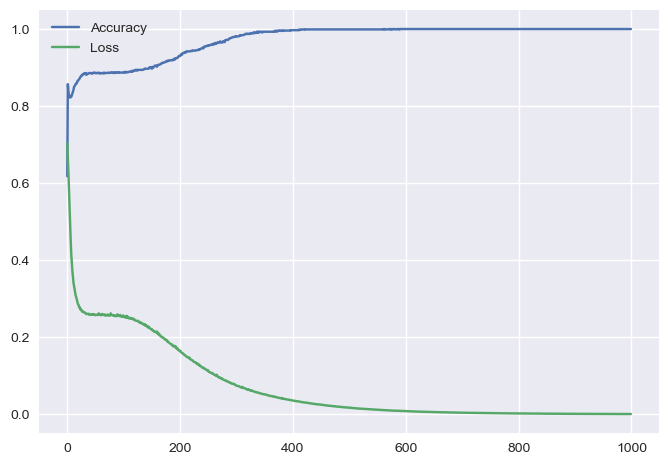

In [28]:
r = list(range(len(accuracies)))
plt.plot(r, accuracies, label='Accuracy')
plt.plot(r, losses, label='Loss')
plt.legend()
plt.show()

In [29]:
summary = SummaryWriter()
summary.add_graph(model,torch.from_numpy(X).float())
summary.close()

2022-09-26 09:44:19.090412: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Run the below cell and play around with it. Double click on `Network` To zoom in. You can also use the scroll wheel to zoom in and out. Next, double click the `sequential` model. What you should see is the network that we defined above: a linear layer followed by a sigmoid activation into another linear layer and a final sigmoid activation. There isn't much exploration of the model or the data that is needed for this exercise but we will use it in the future so I wanted to introduce it now.

In [30]:
%tensorboard --logdir=runs


In [37]:
display.Image('./boundary.gif', width=800, height=600)

### PyTorch Lightning

So you've seen how to train a model and how to run it. You've seen how to load a custom dataset and put it into a `DataLoader` object. You've seen how to use a loss function along with an optimizer to help update the weights of the model and have it learn. Now, if you're new to machine learning or have used Keras before, you're probably thinking this is pretty confusing. You might say to yourself "Chris, this is supposed to be the first ML for coders tutorial. Keras would be sooooo much easier". And in a way you'd be right. For Keras you really can just do something like this:

```python
from tensorflow.keras.layers import Dense, Sequential
model = Sequential([
    Dense(2, activation="sigmoid"),
    Dense(16, activation="sigmoid"),
    Dense(1)
])
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["acc"])
model.fit(X,y)
```

That's all you'd need to train the Keras model. There's a lot of hand wave magic that happens and further down the line we won't be able to rely on it. That being said, you can also do something similar with PyTorch Lightning. You don't always have to train models the way I showed above and so I quickly want to introduce PyTorch Lightning and how we can go about training a model without explicity calling the loss function or the optimizer.

In [32]:
import torch.nn.functional as F

In [33]:
class LitModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.net = model
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.net(X).ravel()
        loss = F.binary_cross_entropy(y_pred, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

        

Now let's instantiate the `LitModel` we defined above and train it

In [34]:
model = LitModel(Network(16))
trainer = pl.Trainer(max_epochs=1000, enable_checkpointing=False, enable_progress_bar=False)
trainer.fit(model, dataloder)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda/v3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name | Type    | Params
---------------------------------
0 | net  | Network | 65    
---------------------------------
65        Trainable params
0         Non-trainable params
65        Total params
0.000     Total estimated model params size (MB)
/opt/anaconda/v3/envs/py39/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `Da

In [35]:
accuracy(model.net, X, y)

1.0

And just like that you can easily train the same neural network without actually having to write a training loop. Under the hood a lot of what you've already seen is happening. There is a loop over the epoch, a call to `loss.backward()` and `optimizer.step()`. There's some other stuff happening as well that we don't need to worry about right now. In future tutorials I will use a combination of PyTorch Lightning and regular PyTorch depending on the task. This will help add variety, show the inner workings of machine learning (to an extent), and show how to abstract away some of the more tedious portions of code and let PL handle them.

### Tasks
If you've made it this far then you're all done! Below are a list of optional but recommended tasks to try. Each number below corresponds to one of the `# $MODIFY <number>` above. So for `1`, go back to `# $MODIFY 1` and modify the code there.

If you want to speed up the original training loop you can pass in `train(..., get_bounary_enery_n_epochs=0)` to disable the saving of the bounary.

1. Try changing the `idx` to 0 and re-run the code. How does the accuracy compare? Can it still fit the data well? Why do you think that is?
2. Change the `opt_idx` to try out a different optimizer (0, 1, 2). Does one optimizer seem to perform better? Does it depend on the dataset?
3. Try a different learning rate (lr). I didn't discuss this much, but each update to weights won't be a full update, but rather a step in that direction. The learning rate dictates how much of a step to take. Try some different values and see what happens. What do you think would happen if the learning rate was >1?
4. Change `num_hidden_units`. What happens to the accuracy?

Congrats! You're all done. See you next time.